In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from glob import glob
from tqdm.notebook import tqdm
from ast import literal_eval
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from sklearn.metrics import accuracy_score
from skimage import exposure
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import cv2
from matplotlib.patches import Rectangle
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, Xception
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.math import confusion_matrix

In [ ]:
import matplotlib.image as mpimg
%matplotlib inline
import cv2
import random 
import skimage.io
import glob
import tqdm

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend, models, layers, regularizers , optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization , Concatenate
from keras.layers import Activation, Flatten, Dense, Dropout ,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
print('Keras version:', keras.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Keras version: 2.5.0
Num GPUs Available:  1


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Datasets/chest_xray.zip", "r")
zip_ref.extractall("dataset")
zip_ref.close()

In [ ]:
imdatagen = ImageDataGenerator()
batches   = imdatagen.flow_from_directory('/content/dataset/chest_xray/train')

Found 5216 images belonging to 2 classes.


In [ ]:
indices = batches.class_indices
labels  = list(indices.keys())

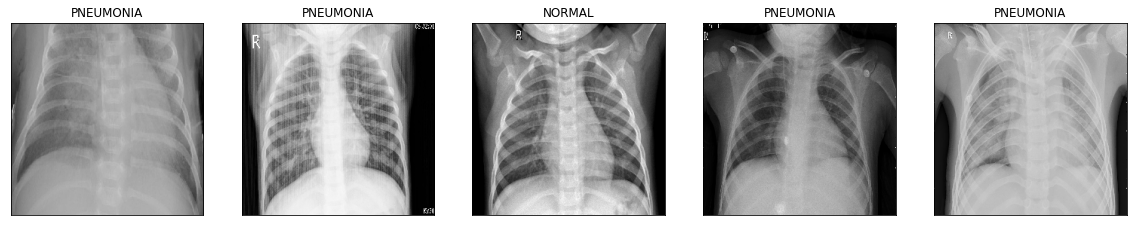

In [ ]:
for X, y in batches:
    fig, ax = plt.subplots(1, 5, figsize=(20, 20))
    
    for i in range(0,5):
        img = X[i].astype('int')
        label = labels[np.argmax(y[i])]
        ax[i].imshow(img)
        ax[i].set_title(label)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    
    plt.show()
    break # We only need the first batch

In [ ]:
# import cv2 
from imageio import imread
img = imread('/content/dataset/chest_xray/train/NORMAL/IM-0115-0001.jpeg')		# assuming color image	 
print(img.shape)

(1858, 2090)


In [ ]:
target_size = (224,224)
train_dataset = imdatagen.flow_from_directory(directory = "/content/dataset/chest_xray/train",
                                          target_size= target_size, #all images should be 300x300 already but just in case
                                          class_mode= 'categorical', # makes 0 and 1 for house/face
                                          color_mode = "grayscale",
                                          batch_size=32
)
validation_dataset = imdatagen.flow_from_directory(directory = "/content/dataset/chest_xray/val", 
                                          target_size= target_size,
                                          class_mode= 'categorical',
                                          color_mode = "grayscale",
                                          batch_size=32       
)
test_dataset = imdatagen.flow_from_directory(directory = "/content/dataset/chest_xray/test",
                                          target_size= target_size,
                                          class_mode= 'categorical',
                                          color_mode = "grayscale",
                                          batch_size=32 
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
print(train_dataset)
print(train_dataset.image_shape)
train_dataset.class_indices

(224, 224, 1)


{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
selected_network = "densenet121"
print(f"Selected network: {selected_network}")

Selected network: densenet121


In [ ]:
# Importing the models:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121

# This function defines our classification network:
def create_model(selected_network):

  # The model is selected amongst the supported architectures:
  model_name = {'densenet121' : DenseNet121}[selected_network]

  base_model = model_name(input_shape=(224,224,1), weights=None, include_top=False)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  output = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=[base_model.input], outputs=[output])

  # The optimiser is stochastic gradient descent with a learning rate of 0.01 and a momentum of 0.9:
  optim = Adam(lr=0.01)

  # The model optimises cross entropy as its loss function and will monitor classification accuracy:
  model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

  # Printing model summary:
  print(model.summary())

  return model

print('Done!')

Done!


In [ ]:
model = create_model(selected_network)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 3136        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
history = model.fit(train_dataset, epochs = 10, batch_size = 64, validation_data = validation_dataset)
print('Done!')

Epoch 1/10
163/163 [==============================] - 54s 275ms/step - loss: 0.3750 - accuracy: 0.8654 - val_loss: 48.5820 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 44s 269ms/step - loss: 0.2204 - accuracy: 0.9158 - val_loss: 6.4526 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 44s 267ms/step - loss: 0.1879 - accuracy: 0.9281 - val_loss: 1.0906 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 44s 267ms/step - loss: 0.1556 - accuracy: 0.9400 - val_loss: 17.9734 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 44s 267ms/step - loss: 0.1508 - accuracy: 0.9448 - val_loss: 104.8949 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 44s 267ms/step - loss: 0.1277 - accuracy: 0.9528 - val_loss: 2.4957 - val_accuracy: 0.4375
Epoch 7/10
163/163 [==============================] - 44s 267ms/step - loss: 0.1295 - accuracy: 0.9534 - val_loss: 33.4263 - v

In [ ]:
batch_size = 32

In [ ]:
Y_pred = model.predict_generator(test_dataset)
y_pred = np.argmax(Y_pred, axis = 1)
print("Confusion Matrix")
print(confusion_matrix(test_dataset.classes, y_pred))

Confusion Matrix
tf.Tensor(
[[ 84 150]
 [134 256]], shape=(2, 2), dtype=int32)


In [ ]:
!mkdir -p saved_model
model.save('saved_model_grayscale/my_model.h5') 

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('saved_model_grayscale/my_model.h5')

# Show the model architecture
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('saved_model/bw_my_model_h5.h5')

# Show the model architecture
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 3136        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
_, acc = model.evaluate(test_dataset, verbose=1)
print('Accuracy: %.3f' % (acc * 100.0))

20/20 [==============================] - 4s 217ms/step - loss: 0.4877 - accuracy: 0.8333
Accuracy: 83.333


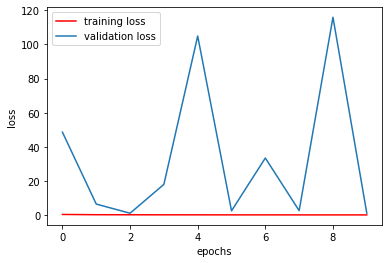

In [ ]:
from matplotlib import pyplot as pyplot

plt.plot(history.history["loss"], 'r', label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

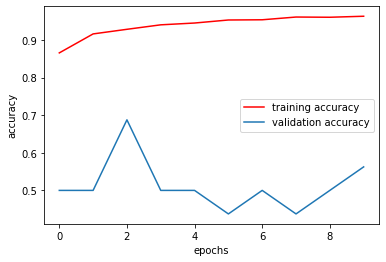

In [ ]:
plt.plot(history.history["accuracy"], 'r', label = "training accuracy")
plt.plot(history.history["val_accuracy"], label = "validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

NameError: ignored